# Template Definition

In [4]:
ROOT_FOLDER = ""

# Eval

In [5]:
def check_relations(predicted, correct):
    """
        compute precision, recall, f1

        and score from 0 to 5 assigned this way:
            - 1 point if relation exists
            - up to 5 points for the cardinality
    """

    total_score = 0
    true_pos = 0
    tp_fn = len(correct)
    tp_fp = len(predicted)
    
    for rel in correct:
        score = 0
        for rel_ in predicted: 
            if set(rel.keys()) == set(rel_.keys()):
                true_pos += 1
                score += 1
                for r in rel.keys():
                    ## unify cardinality format
                    if ".." not in rel[r]:
                        rel[r] = '"' + rel[r].replace('"','') + ".."+ rel[r].replace('"','') +'"'

                    if ".." not in rel_[r]:
                        rel_[r] = '"' + rel_[r].replace('"','') + ".."+ rel_[r].replace('"','') + '"'
        
                    c_min = rel[r].split("..")[0]
                    c_min_ = rel_[r].split("..")[0]

                    if c_min == c_min_:
                        score+=1

                    c_max = rel[r].split("..")[1]
                    c_max_ = rel_[r].split("..")[1]

                    if c_max == c_max_:
                        score+=1

        total_score += score

    if total_score > len(correct) * 5:
        total_score = len(correct) * 5

    if true_pos > 0 :
        precision = true_pos / tp_fp 
        recall = true_pos / tp_fn 
        f1 = 2 * ((precision * recall) / (precision + recall))

        if precision > 1 :
            precision = 1
        if recall > 1:
            recall = 1
        if f1 > 1 :
            f1 = 1
    else:
        precision = 0
        recall = 0
        f1 = 0
    
    return {
        "total_score":total_score,
        "precision": round(precision,2),
        "recall": round(recall,2),
        "f1": round(f1,2),
        "len":len(correct) * 5
    }
            

In [6]:
def check_class(predicted, correct):
    """
    Computes precision, recall, and F1-score between the predicted and correct lists.

    Args:
        predicted (list): The list of predicted values.
        correct (list): The list of correct (ground truth) values.

    Returns:
        dict: A dictionary with precision, recall, and F1-score.
    """

    # precision: how many predicted that are in correct.
    if type(predicted) != type(set()):
        precision =  (len(set(predicted).intersection(set(correct)))) / len(set(predicted))
    else:
        precision =  (len((predicted).intersection((correct)))) / len((predicted))

    
    # recall : how many predicted are not in correct.
    if type(predicted) != type(set()):
        recall =  (len(set(predicted).intersection(set(correct)))) / len(set(correct)) 
    else:
        recall = (len((predicted).intersection((correct)))) / len((correct)) 

    # f1: classic f1
    f1 = 2 * ((precision * recall) / (precision + recall))

    return {
        "precision": round(precision,2),
        "recall": round(recall,2),
        "f1": round(f1,2)
    }

In [7]:
def init_parser():
    with open("/Users/marcocalamo/Downloads/grammar.ebnf", encoding="utf-8") as grammar_file:
        parser = Lark(grammar_file.read())
        return parser


import re 

def parse_text(parser, ref):
    ref = ref.replace('`','')
    ref = ref.replace('plantuml','')
    ref = ref.replace('plaintext', '')

    if not '@startuml' in ref:
        ref = '@startuml\n' + ref
    if not '@enduml' in ref:
        ref = ref+'\n@enduml'
    #ref = ref.replace('@startuml','')
    #ref = ref.replace('@enduml','')

    ref = re.sub(r"<think>.*?</think>", "", ref, flags=re.DOTALL)
    ref = ref.replace('<think>', '')
    ref = ref.replace('</think>', '')
    
    parsed_ref = parser.parse(ref)
    return parsed_ref

def get_from_parsed(parsed_text, to_get="class"):
    found = parsed_text.find_pred(lambda v: v.data.value == to_get)
    
    to_ret = []

    for f in found:
        if to_get == 'relationship':
            one_rel = f.children[0].children            
            first_rel = one_rel[0].children[0].value
            assert one_rel[0].children[0].type == 'CNAME'

            try:
                first_card = one_rel[1].children[0].value
                assert one_rel[1].children[0].type == 'ESCAPED_STRING'
            except:
                first_card = "0..*"

            try:
                second_card = one_rel[5].children[0].value
                assert one_rel[5].children[0].type == 'ESCAPED_STRING'
            except:
                second_card = "0..*"

            second_rel = one_rel[-2].children[0].value
            assert one_rel[-2].children[0].type == 'CNAME'
            
            rel_tuple = {
                first_rel:first_card,
                second_rel:second_card
            }
            
            to_ret.append(rel_tuple)
        elif to_get == 'class':
            to_ret.append(f.children[0].children[0].value)
    
    return to_ret
    
def parse_path(path_to_uml, parser):
    
    if os.path.isfile(path_to_uml):
        with open(path_to_uml) as plant_ref:
            
            ref = plant_ref.read()
            parsed_ref = parse_text(parser, ref)
            found_class = get_from_parsed(parsed_ref, to_get="class")
            found_rel = get_from_parsed(parsed_ref, to_get="relationship")

            return found_class, found_rel
    else:
        raise FileNotFoundError
    

In [8]:
from lark import Lark
import os

In [10]:
parse_path("AuthorsAndBooks/uml.txt", init_parser())

(['Author', 'Book', 'Assignment'],
 [{'Author': '"1"', 'Assignment': '"0..*"'},
  {'Assignment': '"1..*"', 'Book': '"1"'}])

In [7]:
#parse_path("Alpha_Insurance_Basic/result_cot_gpt-3.5-turbo.txt", init_parser())

In [11]:
def evaluate(path_uml, path_to_check, parser):

    # gold class and rel
    class_uml, rel_uml = parse_path(path_uml, parser)

    # candidate class and rel
    class_check, rel_check = parse_path(path_to_check, parser)

    # check class
    res_cl = check_class(class_check, class_uml)

    # check rel
    res_re = check_relations(rel_check, rel_uml)

    return res_cl, res_re

In [20]:
evaluate("Alpha_Insurance_Basic/uml.txt", "Alpha_Insurance_Basic/umlw.txt",init_parser())

({'precision': 1.0, 'recall': 1.0, 'f1': 1.0},
 {'total_score': 49, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'len': 50})

In [11]:
import os
import csv

import multiprocess
from tqdm import tqdm


def process_result_file(args):
    sub_folder, sub_folder_path, filename = args
    uml_file = os.path.join(sub_folder_path, "uml.txt")
    result_file = os.path.join(sub_folder_path, filename)
    model_name = "-".join(filename.replace(".txt", "").split("_")[1:])
    parser = init_parser()
    
    try:
        results = evaluate(uml_file, result_file, parser)
        return [sub_folder, model_name, results[0]["precision"], results[0]["recall"], results[0]["f1"],
                                        results[1]["precision"], results[1]["recall"], results[1]["f1"],
                                        results[1]["total_score"], results[1]["len"]]
    except Exception as e:
        #print("Exception at", sub_folder, model_name)
        with open("trace.txt", mode="a") as t:
            t.write(str(e) + str(sub_folder)+str (model_name))
        return None

def process_folders(root_folder):
    csv_file = os.path.join(root_folder, "evaluation_results.csv")

    pool = multiprocess.Pool()
    tasks = []
    
    for sub_folder in os.listdir(root_folder):
        sub_folder_path = os.path.join(root_folder, sub_folder)
        if not os.path.isdir(sub_folder_path):
            continue

        uml_file = os.path.join(sub_folder_path, "uml.txt")
        if not os.path.exists(uml_file):
            continue
        
        for filename in os.listdir(sub_folder_path):
            if filename.startswith("result_") and filename.endswith(".txt"):
                tasks.append((sub_folder, sub_folder_path, filename))
    
    #results = pool.imap(process_result_file, tasks)
    results = []
    max_ = len(tasks)
    with multiprocess.Pool(processes=12) as p, tqdm(total=max_) as pbar:
        for result in p.imap(process_result_file, tasks):
            pbar.update()
            pbar.refresh()
            # do something with `result`
           
            if result != None:
                results.append(result)
           

    
    pool.close()
    pool.join()
    
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["sub_folder_name", "model_name", 
                                             "precision_class", "recall_class", "f1_class",
                                             "precision_rel", "recall_rel", "f1_rel", "score_rel", "max_score"])

        print(len([r for r in results if r is not None]))
        for result in results:
            if result:
                writer.writerow(result)




def process_folders_old(root_folder):
    csv_file = os.path.join(root_folder, "evaluation_results.csv")
    header_written = False
    
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        for sub_folder in os.listdir(root_folder):
            sub_folder_path = os.path.join(root_folder, sub_folder)
            if not os.path.isdir(sub_folder_path):
                continue

            uml_file = os.path.join(sub_folder_path, "uml.txt")
            if not os.path.exists(uml_file):
                continue
            
            for filename in os.listdir(sub_folder_path):
                if filename.startswith("result_") and filename.endswith(".txt"):
                    result_file = os.path.join(sub_folder_path, filename)
                    model_name = "-".join(filename.replace(".txt", "").split("_")[1:])
                    parser = init_parser()
                    try:
                        results = evaluate(uml_file, result_file, parser)
                        if not header_written:
                            writer.writerow(["sub_folder_name", "model_name", 
                                             "precision_class", "recall_class", "f1_class",
                                             "precision_rel", "recall_rel", "f1_rel", "score_rel", "max_score"])
                            header_written = True
                        writer.writerow([sub_folder, model_name, results[0]["precision"], results[0]["recall"], results[0]["f1"],
                                        results[1]["precision"], results[1]["recall"], results[1]["f1"],
                                        results[1]["total_score"], results[1]["len"]])
                    except Exception as e:
                        print(e) 
                        print("Exception at", sub_folder, model_name)
                        with open("trace.txt", mode="a") as t:
                            t.write(str(e) + str(sub_folder)+str (model_name))
                        #raise Exception

In [12]:
%%time
process_folders(ROOT_FOLDER)

100%|███████████████████████████████████████| 1373/1373 [00:16<00:00, 81.91it/s]


1186
CPU times: user 1.8 s, sys: 451 ms, total: 2.25 s
Wall time: 16.9 s


# Plot Data

In [13]:
def add_counts(ax, df):
    for c in ax.containers:
        # Extract heights and match with correct counts
        labels = [f'N={int(row["count"])}' for (idx, row) in (df.iterrows()) ]
        # Add the count labels to the bars
        try:
            ax.bar_label(c, labels=labels, label_type='edge', fontsize=10, padding=3)
        except:
            continue

In [14]:
# Define a list of possible prefixes
prefixes = ['cot', 'cot2', 'few', 'few2']

# Function to extract base model name and result type based on prefixes
def extract_base_and_type(model_name):
    for prefix in prefixes:
        if model_name.startswith(f'{prefix}-'):
            return model_name.replace(f'{prefix}-', ''), prefix
    return model_name, 'standard'

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data_class(csv):
    # Load the CSV file
    df = pd.read_csv(csv)
    
    # Extract the base model name and determine result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x))
    )

    # Compute averages and instance counts
    avg_metrics = df.groupby(['base_model_name', 'model_name', 'result_type']).agg(
        f1_class_avg=('f1_class', 'mean'),
        count=('model_name', 'count')
    ).reset_index()

    
    # Set seaborn style
    sns.set_theme(style='whitegrid')
    
    # Define a color palette for base model names
    unique_base_models = avg_metrics['base_model_name'].unique()
    base_palette = sns.color_palette("tab10", len(unique_base_models))
    color_map = {model: base_palette[i] for i, model in enumerate(unique_base_models)}
    
    # Generate colors for the bars, ensuring each base model has the same color for both result types
    avg_metrics['color'] = avg_metrics['base_model_name'].map(color_map)
    
    # Plot average f1_class per model with result types
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='base_model_name', y='f1_class_avg', hue='result_type', 
        data=avg_metrics, palette='husl' #palette=[color_map[m] for m in avg_metrics['base_model_name']]
    )

    # Annotate counts on bars correctly
    for count, score in zip(avg_metrics['count'], avg_metrics['f1_class_avg']):        
        for p in ax.patches:
            if p.get_height() == score:
                ax.annotate(f'N={count}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10)
    
    
    plt.title('Average F1 Class per Model')
    plt.xlabel('Model Name')
    plt.ylabel('Average F1 Class')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Result Type')
    plt.show()


def plot_data_rel(csv):
    df = pd.read_csv(csv)
    
    # Extract the base model name and determine result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x))
    )

    # Compute averages and instance counts
    avg_metrics = df.groupby(['base_model_name', 'model_name', 'result_type']).agg(
        f1_rel_avg=('f1_rel', 'mean'),
        count=('model_name', 'count')
    ).reset_index()

    
    # Set seaborn style
    sns.set_theme(style='whitegrid')
    
    # Define a color palette for base model names
    unique_base_models = avg_metrics['base_model_name'].unique()
    base_palette = sns.color_palette("tab10", len(unique_base_models))
    color_map = {model: base_palette[i] for i, model in enumerate(unique_base_models)}
    
    # Generate colors for the bars, ensuring each base model has the same color for both result types
    avg_metrics['color'] = avg_metrics['base_model_name'].map(color_map)
    
    # Plot average f1_class per model with result types
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='base_model_name', y='f1_rel_avg', hue='result_type', 
        data=avg_metrics, palette='husl' #palette=[color_map[m] for m in avg_metrics['base_model_name']]
    )

    # Annotate counts on bars correctly
    for count, score in zip(avg_metrics['count'], avg_metrics['f1_rel_avg']):        
        for p in ax.patches:
            if p.get_height() == score:
                ax.annotate(f'N={count}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10)
    
        
    plt.title('Average F1 Association per Model')
    plt.xlabel('Model Name')
    plt.ylabel('Average F1 Assoc')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Result Type')
    plt.show()


def plot_data_score(csv):
    # Load the CSV file
    df = pd.read_csv(csv)
    
    # Extract the base model name and determine result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x))
    )

    # Compute averages and instance counts
    avg_metrics = df.groupby(['base_model_name', 'model_name', 'result_type']).agg(
        score_avg=('score_rel', 'mean'),
        count=('model_name', 'count')
    ).reset_index()

    
    # Set seaborn style
    sns.set_theme(style='whitegrid')
    
    # Define a color palette for base model names
    unique_base_models = avg_metrics['base_model_name'].unique()
    base_palette = sns.color_palette("tab10", len(unique_base_models))
    color_map = {model: base_palette[i] for i, model in enumerate(unique_base_models)}
    
    # Generate colors for the bars, ensuring each base model has the same color for both result types
    avg_metrics['color'] = avg_metrics['base_model_name'].map(color_map)
    
    # Plot average f1_class per model with result types
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='base_model_name', y='score_avg', hue='result_type', 
        data=avg_metrics, palette='husl' #palette=[color_map[m] for m in avg_metrics['base_model_name']]
    )

    # Annotate counts on bars correctly
    for count, score in zip(avg_metrics['count'], avg_metrics['score_avg']):        
        for p in ax.patches:
            if p.get_height() == score:
                ax.annotate(f'N={count}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10)
    
    plt.title('Average Score per Model')
    plt.xlabel('Model Name')
    plt.ylabel('Average Score')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Result Type')
    plt.show()

In [16]:
def plot_data_class_pc(csv):
    # Load the CSV file
    df = pd.read_csv(csv)
    
    # Extract the base model name and determine result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x))
    )

    # Compute averages and instance counts
    avg_metrics = df.groupby(['sub_folder_name', 'base_model_name', 'model_name', 'result_type']).agg(
        f1_class_avg=('f1_class', 'mean'),
        count=('model_name', 'count')
    ).reset_index()

    
    # Set seaborn style
    sns.set_theme(style='whitegrid')
    
    # Define a color palette for base model names
    unique_base_models = avg_metrics['base_model_name'].unique()
    base_palette = sns.color_palette("tab10", len(unique_base_models))
    color_map = {model: base_palette[i] for i, model in enumerate(unique_base_models)}
    
    # Generate colors for the bars, ensuring each base model has the same color for both result types
    avg_metrics['color'] = avg_metrics['base_model_name'].map(color_map)
    
    # Plot average f1_class per model with result types
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='sub_folder_name', y='f1_class_avg', hue='result_type', 
        data=avg_metrics, palette='husl' #palette=[color_map[m] for m in avg_metrics['base_model_name']]
    )

    
    
    plt.title('Average F1 Class per Case')
    plt.xlabel('Model Name')
    plt.ylabel('Average F1 Class')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Result Type')
    plt.show()

def plot_data_rel_pc(csv):
    df = pd.read_csv(csv)
    
    # Extract the base model name and determine result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x))
    )

    # Compute averages and instance counts
    avg_metrics = df.groupby(['sub_folder_name', 'base_model_name', 'model_name', 'result_type']).agg(
        f1_rel_avg=('f1_rel', 'mean'),
        count=('model_name', 'count')
    ).reset_index()

    
    # Set seaborn style
    sns.set_theme(style='whitegrid')
    
    # Define a color palette for base model names
    unique_base_models = avg_metrics['base_model_name'].unique()
    base_palette = sns.color_palette("tab10", len(unique_base_models))
    color_map = {model: base_palette[i] for i, model in enumerate(unique_base_models)}
    
    # Generate colors for the bars, ensuring each base model has the same color for both result types
    avg_metrics['color'] = avg_metrics['base_model_name'].map(color_map)
    
    # Plot average f1_class per model with result types
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='sub_folder_name', y='f1_rel_avg', hue='result_type', 
        data=avg_metrics, palette='husl' #palette=[color_map[m] for m in avg_metrics['base_model_name']]
    )

        
    plt.title('Average F1 Association per Case')
    plt.xlabel('Model Name')
    plt.ylabel('Average F1 Assoc')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Result Type')
    plt.show()


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data_p_class(csv):
    # Load the CSV file
    df = pd.read_csv(csv)
    
    # Extract the base model name and determine result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x))
    )

    # Compute averages and instance counts
    avg_metrics = df.groupby(['base_model_name', 'model_name', 'result_type']).agg(
        f1_class_avg=('precision_class', 'mean'),
        count=('model_name', 'count')
    ).reset_index()

    
    # Set seaborn style
    sns.set_theme(style='whitegrid')
    
    # Define a color palette for base model names
    unique_base_models = avg_metrics['base_model_name'].unique()
    base_palette = sns.color_palette("tab10", len(unique_base_models))
    color_map = {model: base_palette[i] for i, model in enumerate(unique_base_models)}
    
    # Generate colors for the bars, ensuring each base model has the same color for both result types
    avg_metrics['color'] = avg_metrics['base_model_name'].map(color_map)
    
    # Plot average f1_class per model with result types
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='base_model_name', y='f1_class_avg', hue='result_type', 
        data=avg_metrics, palette='rocket' #palette=[color_map[m] for m in avg_metrics['base_model_name']]
    )

    # Annotate counts on bars correctly
    for count, score in zip(avg_metrics['count'], avg_metrics['f1_class_avg']):        
        for p in ax.patches:
            if p.get_height() == score:
                ax.annotate(f'N={count}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10)
    
    
    plt.title('Average Precision Class per Model')
    plt.xlabel('Model Name')
    plt.ylabel('Average Precision Class')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Result Type')
    plt.show()


def plot_data_rel(csv):
    df = pd.read_csv(csv)
    
    # Extract the base model name and determine result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x))
    )

    # Compute averages and instance counts
    avg_metrics = df.groupby(['base_model_name', 'model_name', 'result_type']).agg(
        f1_rel_avg=('f1_rel', 'mean'),
        count=('model_name', 'count')
    ).reset_index()

    
    # Set seaborn style
    sns.set_theme(style='whitegrid')
    
    # Define a color palette for base model names
    unique_base_models = avg_metrics['base_model_name'].unique()
    base_palette = sns.color_palette("tab10", len(unique_base_models))
    color_map = {model: base_palette[i] for i, model in enumerate(unique_base_models)}
    
    # Generate colors for the bars, ensuring each base model has the same color for both result types
    avg_metrics['color'] = avg_metrics['base_model_name'].map(color_map)
    
    # Plot average f1_class per model with result types
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='base_model_name', y='f1_rel_avg', hue='result_type', 
        data=avg_metrics, palette='husl' #palette=[color_map[m] for m in avg_metrics['base_model_name']]
    )

    # Annotate counts on bars correctly
    for count, score in zip(avg_metrics['count'], avg_metrics['f1_rel_avg']):        
        for p in ax.patches:
            if p.get_height() == score:
                ax.annotate(f'N={count}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10)
    
        
    plt.title('Average F1 Association per Model')
    plt.xlabel('Model Name')
    plt.ylabel('Average F1 Assoc')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Result Type')
    plt.show()


def plot_data_score(csv):
    # Load the CSV file
    df = pd.read_csv(csv)
    
    # Extract the base model name and determine result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x))
    )

    # Compute averages and instance counts
    avg_metrics = df.groupby(['base_model_name', 'model_name', 'result_type']).agg(
        score_avg=('score_rel', 'mean'),
        count=('model_name', 'count')
    ).reset_index()

    
    # Set seaborn style
    sns.set_theme(style='whitegrid')
    
    # Define a color palette for base model names
    unique_base_models = avg_metrics['base_model_name'].unique()
    base_palette = sns.color_palette("tab10", len(unique_base_models))
    color_map = {model: base_palette[i] for i, model in enumerate(unique_base_models)}
    
    # Generate colors for the bars, ensuring each base model has the same color for both result types
    avg_metrics['color'] = avg_metrics['base_model_name'].map(color_map)
    
    # Plot average f1_class per model with result types
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x='base_model_name', y='score_avg', hue='result_type', 
        data=avg_metrics, palette='husl' #palette=[color_map[m] for m in avg_metrics['base_model_name']]
    )

    # Annotate counts on bars correctly
    for count, score in zip(avg_metrics['count'], avg_metrics['score_avg']):        
        for p in ax.patches:
            if p.get_height() == score:
                ax.annotate(f'N={count}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10)
    
    plt.title('Average Score per Model')
    plt.xlabel('Model Name')
    plt.ylabel('Average Score')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Result Type')
    plt.show()

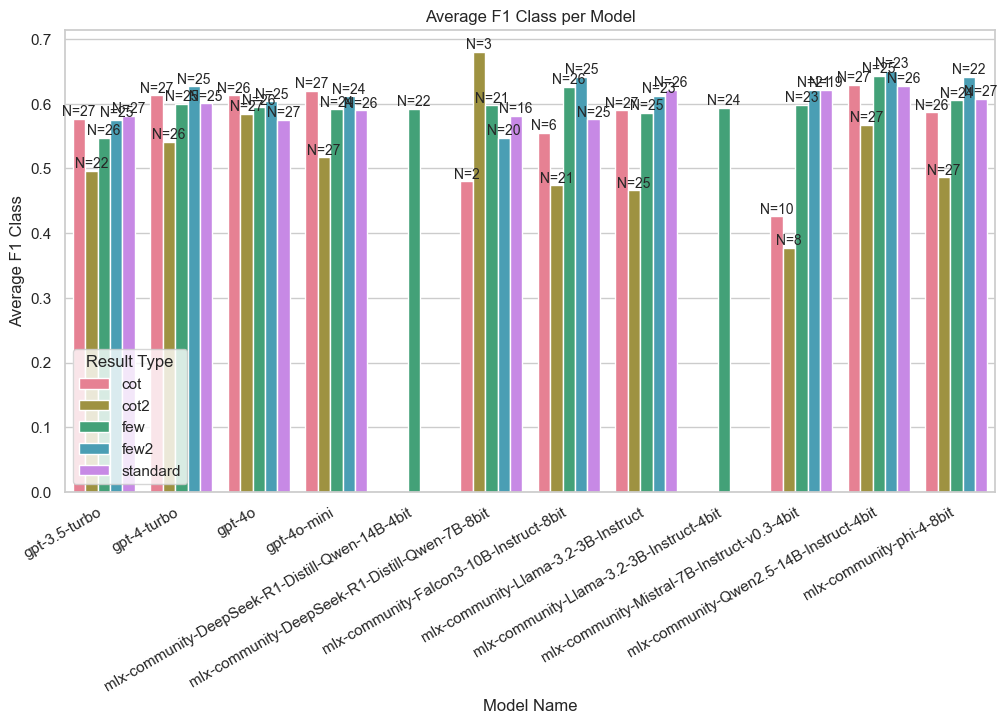

In [18]:
plot_data_class("evaluation_results.csv")

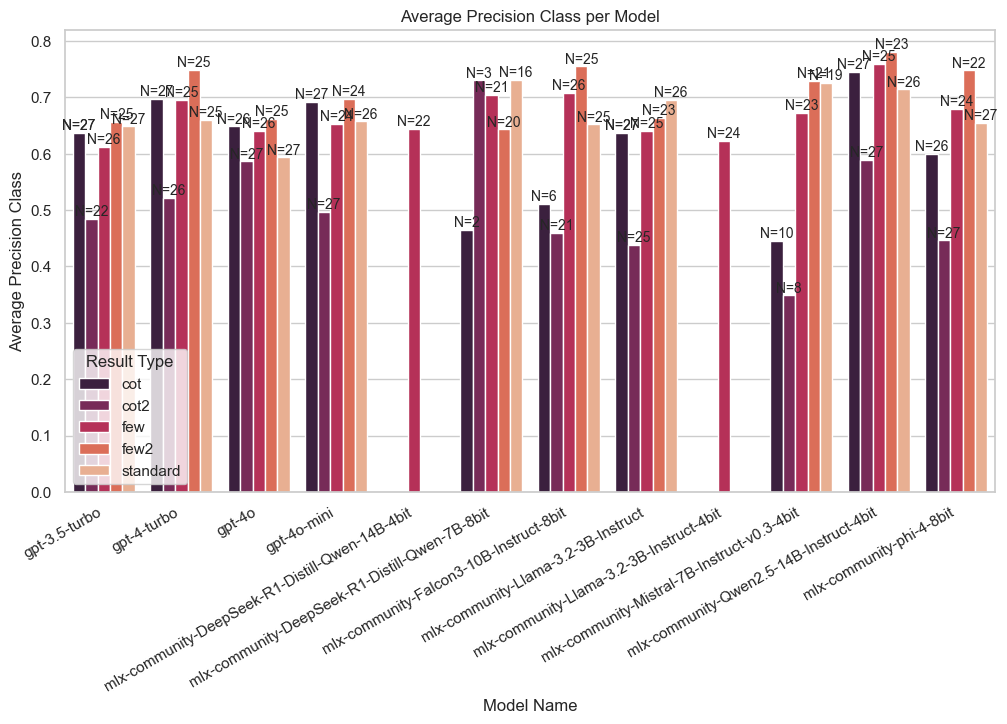

In [19]:
plot_data_p_class("evaluation_results.csv")

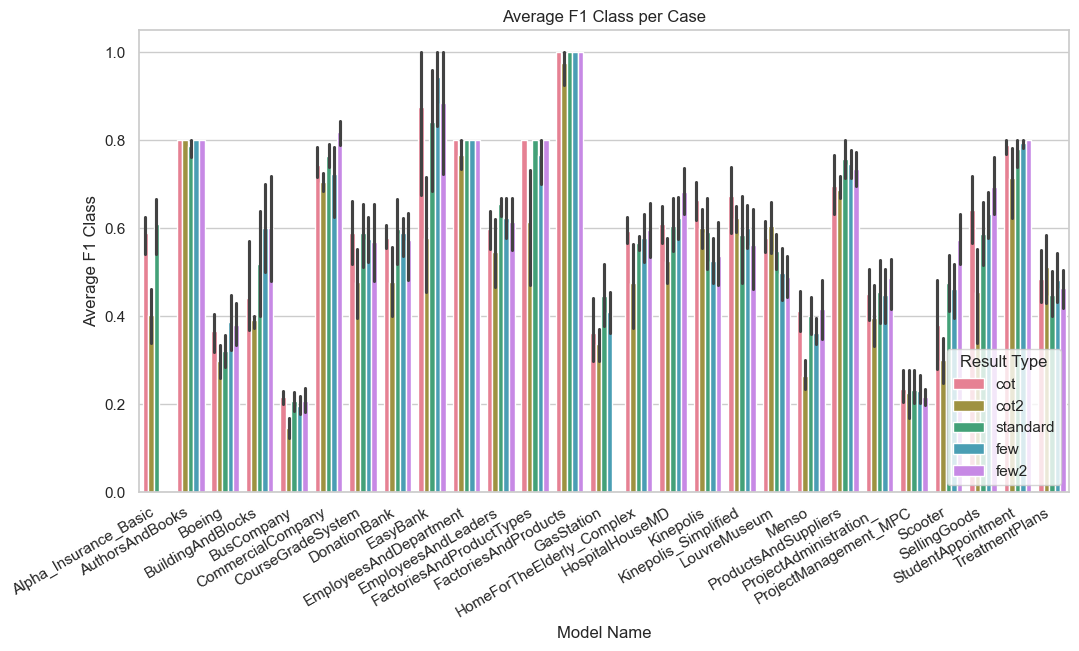

In [20]:
plot_data_class_pc("evaluation_results.csv")

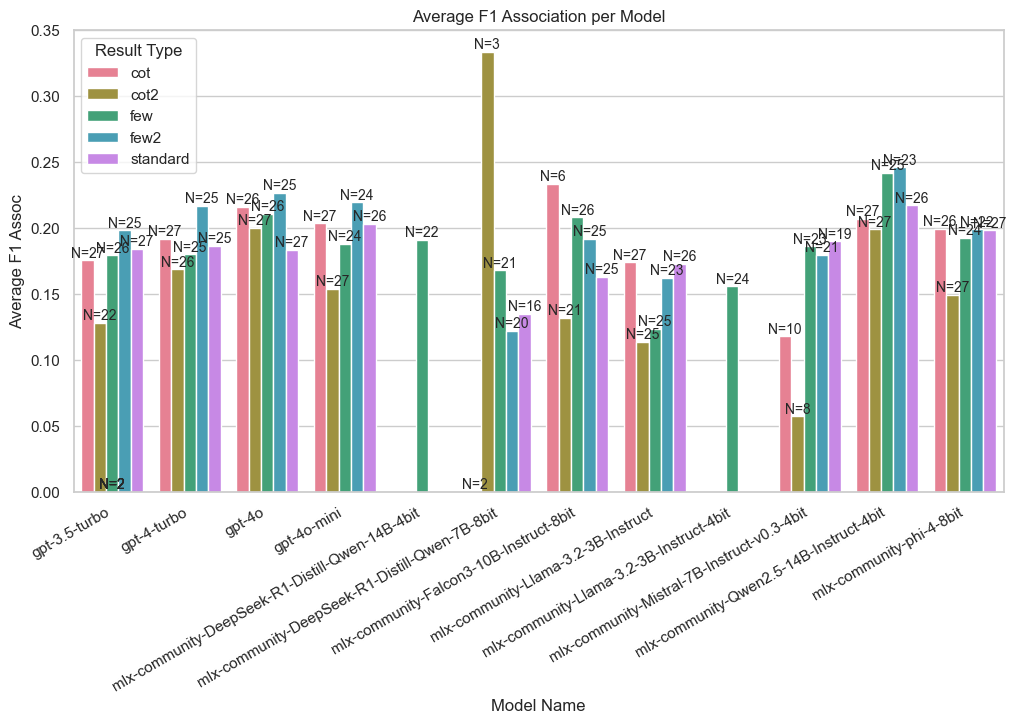

In [21]:
plot_data_rel("evaluation_results.csv") 

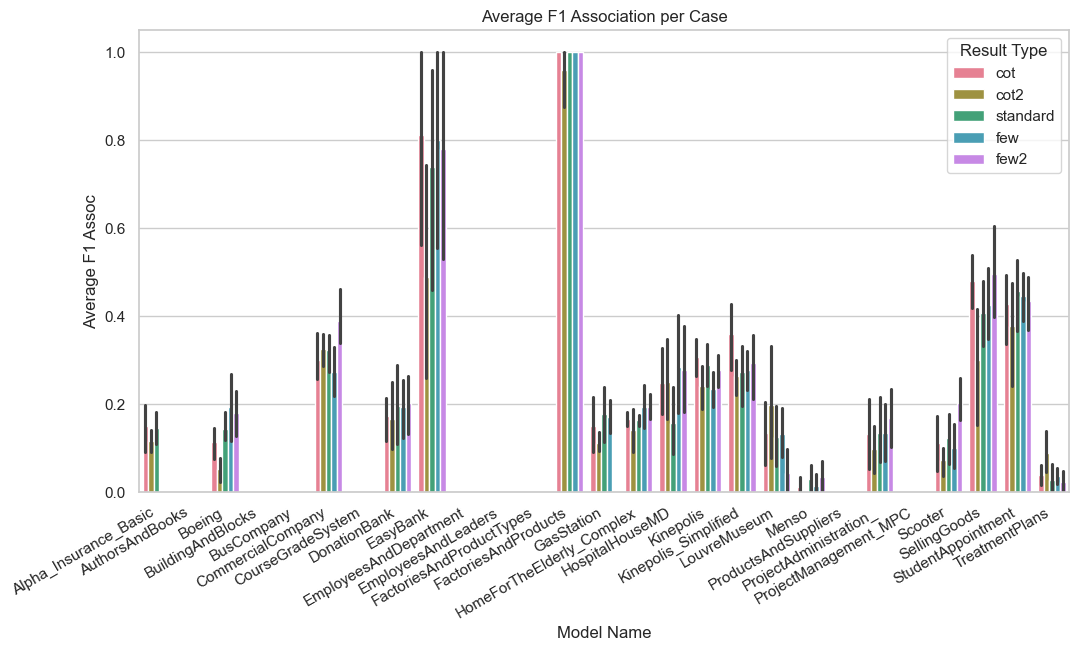

In [22]:
plot_data_rel_pc("evaluation_results.csv") 

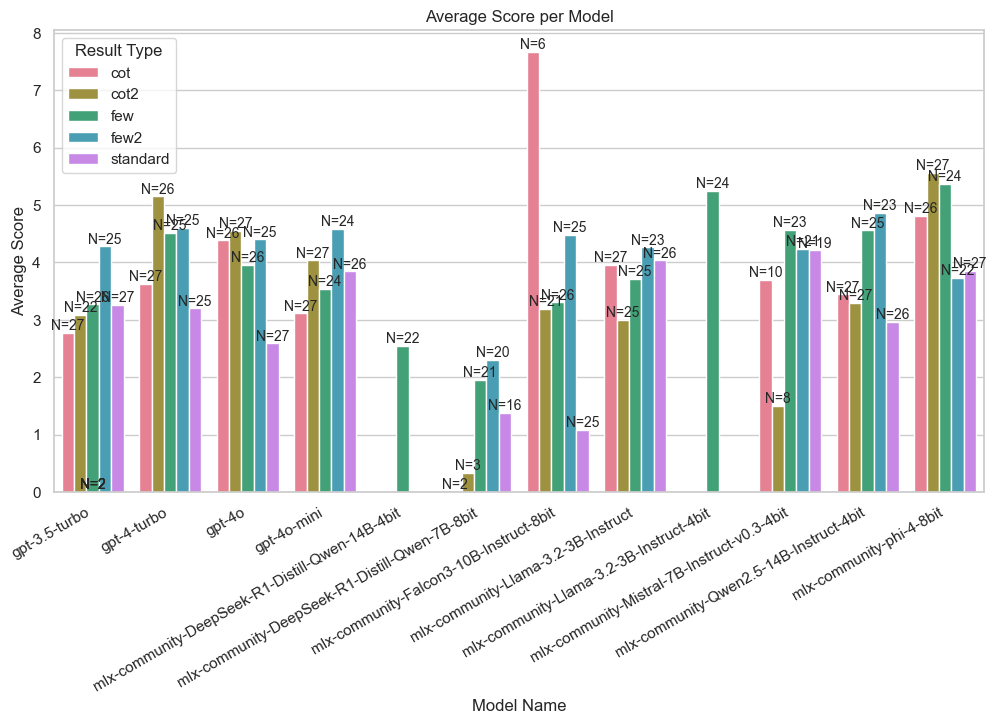

In [23]:
plot_data_score("evaluation_results.csv")

In [24]:
# avg per case
# precision - recall

In [25]:
# Function to extract base model name and result type based on prefixes
def extract_base_and_type(model_name, prefixes):
    for prefix in prefixes:
        if model_name.startswith(f'{prefix}-'):
            return model_name.replace(f'{prefix}-', ''), prefix
    return model_name, 'standard'

# Function to plot aggregated Precision, Recall, and F1-score per prefix
def plot_aggregated_metrics(prefixes, csv):

    df = pd.read_csv(csv)
    # Function to plot aggregated metrics (averaging class and relation) per prefix
    # Extract base model name and result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x, prefixes))
    )

    # Compute averaged metrics per result type (prefix)
    aggregated_metrics = df.groupby('result_type').agg(
        precision_avg=('precision_class', lambda x: (x.mean() + df.loc[x.index, 'precision_rel'].mean()) / 2),
        recall_avg=('recall_class', lambda x: (x.mean() + df.loc[x.index, 'recall_rel'].mean()) / 2),
        f1_avg=('f1_class', lambda x: (x.mean() + df.loc[x.index, 'f1_rel'].mean()) / 2)
    ).reset_index()

    # Convert data for seaborn
    melted_df = aggregated_metrics.melt(id_vars=['result_type'], 
                                        var_name='Metric', 
                                        value_name='Score')

    # Set seaborn style
    sns.set_theme(style='whitegrid')

    # Plot bar chart with grouped metrics
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='result_type', y='Score', hue='Metric', data=melted_df, palette='husl')

    # Add labels above bars
    for c in ax.containers:
        ax.bar_label(c, fmt="%.2f", fontsize=10, padding=3)

    plt.title('Aggregated Precision, Recall, and F1-score per Prefix')
    plt.xlabel('Prefix')
    plt.ylabel('Average Score')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Metric')
    plt.show()

# Example usage:
# df = pd.read_csv('your_file.csv')
# plot_aggregated_metrics(df, prefixes)

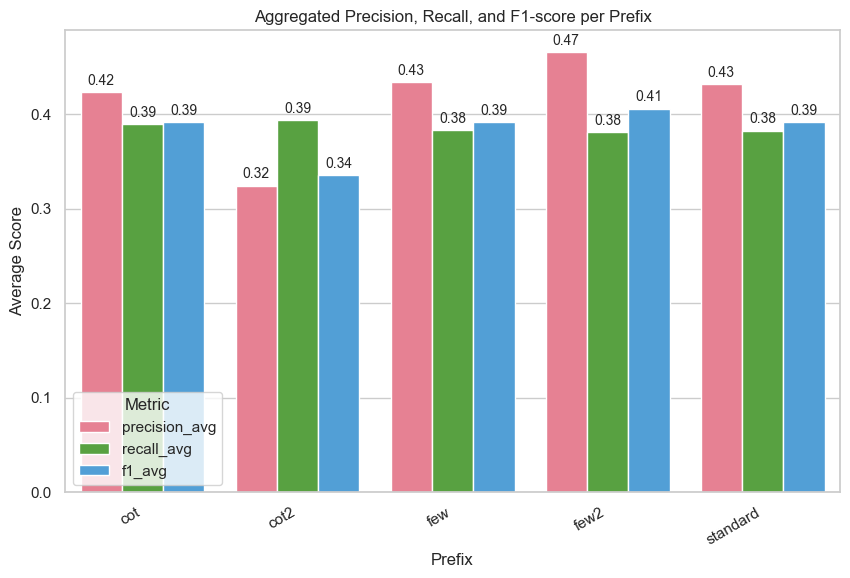

In [26]:
plot_aggregated_metrics(prefixes, "evaluation_results.csv")

In [27]:
# Function to extract base model name and result type based on prefixes
def extract_base_and_type(model_name, prefixes):
    if not isinstance(model_name, str):
        return str(model_name), 'standard'  # Ensure all names are strings
    for prefix in prefixes:
        if model_name.startswith(f'{prefix}-'):
            return model_name.replace(f'{prefix}-', ''), prefix
    return model_name, 'standard'

# Function to compute aggregated and weighted metrics
def compute_aggregated_metrics(df, group_by):
    aggregated_df = df.groupby(group_by).agg(
        precision_avg=('precision_class', lambda x: (x.mean() + df.loc[x.index, 'precision_rel'].mean()) / 2),
        recall_avg=('recall_class', lambda x: (x.mean() + df.loc[x.index, 'recall_rel'].mean()) / 2),
        f1_avg=('f1_class', lambda x: (x.mean() + df.loc[x.index, 'f1_rel'].mean()) / 2),
        count=('model_name', 'count')  # Count occurrences
    ).reset_index()

    # Compute weighted F1-score: (sum of individual F1 * N) / total N
    total_count = aggregated_df['count'].sum()
    aggregated_df['weighted_f1'] = (aggregated_df['f1_avg'] * aggregated_df['count']) / total_count

    return aggregated_df

# Function to plot aggregated metrics
def plot_aggregated_metrics_2(prefixes, csv):
    df = pd.read_csv(csv)

    # Ensure model_name is a string
    df['model_name'] = df['model_name'].astype(str)

    # Extract base model name and result type
    df[['base_model_name', 'result_type']] = df['model_name'].apply(
        lambda x: pd.Series(extract_base_and_type(x, prefixes))
    )

    # Compute aggregated metrics per prefix
    aggregated_prefix = compute_aggregated_metrics(df, 'result_type')
    aggregated_prefix.rename(columns={'result_type': 'Category_Value'}, inplace=True)
    aggregated_prefix['Category'] = 'Prefix'

    # Compute aggregated metrics per model name
    aggregated_model = compute_aggregated_metrics(df, 'base_model_name')
    aggregated_model.rename(columns={'base_model_name': 'Category_Value'}, inplace=True)
    aggregated_model['Category'] = 'Model Name'

    # Combine both aggregations
    aggregated_df = pd.concat([aggregated_prefix, aggregated_model], ignore_index=True)

    # Melt for seaborn
    melted_df = aggregated_df.melt(id_vars=['Category', 'Category_Value', 'count'], 
                                   var_name='Metric', 
                                   value_name='Score')

    # Ensure x-axis labels are treated as categorical
    melted_df['Category_Value'] = melted_df['Category_Value'].astype(str)

    # Set seaborn style
    sns.set_theme(style='whitegrid')

    # Plot bar chart with grouped metrics
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Category_Value', y='Score', hue='Metric', data=melted_df, palette='husl')

    # Add labels above bars with metric value and count (N)
    for c in ax.containers:
        labels = [f"{v.get_height():.2f} (N={int(n)})" if (v.get_height() > 0) else '' 
                  for v, n in zip(c, melted_df['count'])]
        ax.bar_label(c, labels=labels, fontsize=10, padding=3)

    plt.title('Aggregated Precision, Recall, F1-score & Weighted F1 per Prefix and Model Name')
    plt.xlabel('Prefix / Model Name')
    plt.ylabel('Average Score')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Metric')
    plt.show()

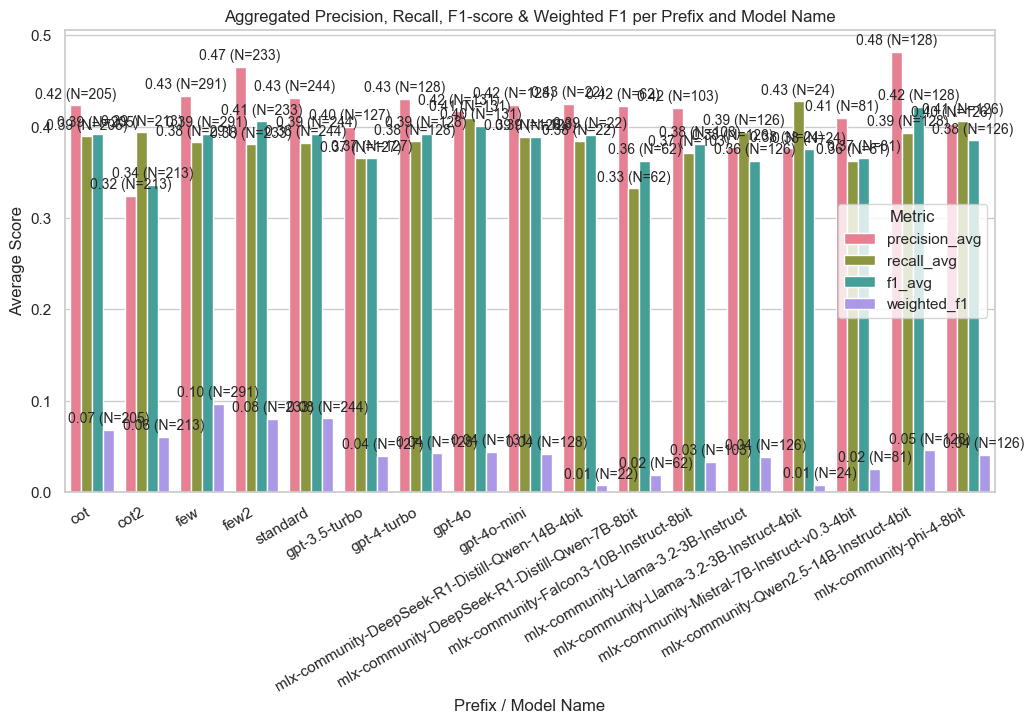

In [28]:
plot_aggregated_metrics_2(prefixes, "evaluation_results.csv")